# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
#import gzip
#import pandas as pd

#def parse(path):
#    g = gzip.open(path, 'r')
#    for l in g:
#        yield eval(l)

**Reviews**

In [2]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10
#for l in parse('steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1

In [3]:
#data_reviews = pd.DataFrame(data_reviews)

In [4]:
#data_reviews.head()

In [5]:
#data_reviews.to_csv('new_data_reviews.csv')

**Games**

In [6]:
#data_games = []
#for l in parse('steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games)

In [7]:
#data_games.head()

In [8]:
#data_games.to_csv('new_data_games.csv')

### 1. ANÁLISIS EXPLORATORIO DE DATOS

#### 1.1 ANÁLISIS INICIAL

__Qué es Steam?__  
Steam es un sistema de distribución de juegos multiplataforma en línea, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 3000 juegos, lo que lo convierte en una plataforma ideal para el tipo de trabajo que aquí se presenta. El conjunto de datos contiene registros de más de 3000 juegos y aplicaciones.  

Steam es un servicio de distribución digital de videojuegos de Valve. Se lanzó como un cliente de software independiente en septiembre de 2003 como una forma de que Valve proporcionara actualizaciones automáticas para sus juegos y se expandió para incluir juegos de editores externos. Steam también se ha expandido a una tienda digital móvil y basada en la web en línea.  

De acuerdo con la popularidad del juego, la similitud de la descripción del juego, la calidad del juego y la preferencia del jugador por el juego, recomiendan el juego correspondiente al jugador del juego, de modo que Steam obtenga un mayor grado de satisfacción del cliente.

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset # convertimos nuestro Dataframe en Dataset
                             # es la estructura de datos que utiliza Surprise!, para almacenar la Matriz de Utilidad
                             # es la forma de almacenar datos con menos memoria, ya que la Matriz de Utilidad es muy grande     
from surprise import Reader # lector de Surprise!
from surprise.model_selection import train_test_split
# quita calificacione de usuario-película de forma aleatoria s/ toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a una película

2. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

__DATA REVIEW__

In [10]:
new_data_review = pd.read_csv('new_data_reviews.csv')

In [11]:
new_data_review.shape # Filas y columnas

(779307, 13)

* *El Dataset, cuenta con **779.307 Filas**, y **13 Columnas**.*

In [12]:
new_data_review.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


__DATA GAMES__

In [13]:
new_data_games = pd.read_csv('new_data_games.csv')

In [14]:
new_data_games.shape # Filas y columnas

(32135, 17)

* *El Dataset, cuenta con **32.135 Filas**, y **13 Columnas**.*

In [15]:
new_data_games.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


3. __Valores Faltantes:__ se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna. En un principio es a mera exposición, ya que por el momento no vamos a descartar ninguno de ellos,ni realizar imputación de datos.

__DATA REVIEW__

In [16]:
new_data_review.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` **98%** (764.719);*  
    *2. `found_funny` **86%** (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

__DATA GAMES__

In [17]:
new_data_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todos las Variables tienen elementos faltantes. Detallamos las principales:*  
    *1. `discount_price` **98%** (31.910);*  
    *2. `metascore` **98%** (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
    
* *Cabe aclarar que el `id` de los juegos, tienen 2 valores faltantes.*
* *`metascore` refiere a la media de todas las reseñas recibidas para dicho juego.*

In [18]:
# new_data_games[new_data_games.id == '35140']

#### 1.2 FILTRO COLABORATIVO

* __Recomendación Colaborativa:__ se buscan Usuarios similares a mi, y de acuerdo a ello, se usan los productos que ellos consumen para recomendarmelos a mí (que yo no he usado, consumido, escuchado, etc.). Se utiliza lo que se sabe de mí y en función de ello se buscan usuarios que se parecen a mí.
    * Ventajas: no necesito tener info acerca de los productos.
    * Desventajas: necesitamos tener la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
    
* Necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

CASO PARTICULAR STEAM
* No hay registros tanto en el sitio web Steam, sobre las calificaciones continuas de estos usuarios. En realidad, en la plataforma, los usuarios sólo dan "Recomendación" o "No Recomendación", lo que significa revisiones binarias, positivas y negativas, incluso en el sitio web del usuario, todavía no hay ningún mecanismo sobre las calificaciones continuas como una estrella a cinco estrellas.
* Para obtener calificaciones continuas sobre la interacción entre los usuarios y los juegos, debemos suponer un mecanismo de interacción de calificación de los juegos por parte de los usuarios. Ya que las concentraciones de los usuarios sobre los juegos pueden ser ajustadas por sus `tiempos de juego`, podemos asumir que el tiempo de juego es una información bastante persuasiva sobre los intereses de los usuarios.
* Por lo tanto, aquí asumimos que la mediana del tiempo de juego es una parte muy importante de los intereses.

1. Seleccionamos aquellos **features que nos seran útiles** a la hora de aplicar un **filtro colaborativo**.

DATA REVIEWS

In [19]:
df = pd.read_csv('new_data_reviews.csv', dtype={'hours': np.float, 'product_id': np.int})
print(df.shape)
df.head()

(779307, 13)


,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


In [20]:
df1 = df[['username','hours','product_id']]
df1

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


In [21]:
df1.isnull().sum()

username        18
hours         2637
product_id       0
dtype: int64

In [22]:
df1.username.fillna("nan", inplace = True)

C:\Users\Ale\anaconda3\envs\ds\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [23]:
df1.isnull().sum()

username         0
hours         2637
product_id       0
dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1['username'] = le.fit_transform(df1['username'])
print(df1['username'])

0          62543
1          26902
2         434602
3         347902
4         503849
           ...  
779302    366849
779303    242193
779304    276240
779305    168748
779306    147490
Name: username, Length: 779307, dtype: int32


<ipython-input-24-4630c51b0d71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['username'] = le.fit_transform(df1['username'])


In [25]:
df1

,username,hours,product_id
0,62543,0.1,725280
1,26902,13.2,328100
2,434602,0.1,725280
3,347902,7.8,631920
4,503849,8.2,35140
...,...,...,...
779302,366849,783.5,252490
779303,242193,55.1,252490
779304,276240,203.5,252490
779305,168748,139.8,252490


CONSIDERACIÓN DE HORAS DE JUEGO
* Con el fin de comparar la mediana del tiempo de juego, vamos a comparar la mediana del tiempo de juego de cada usuario individual en 'X' juego, con la mediana del tiempo de juego de todos los usuarios.
* Luego usaremos el algoritmo para dividir esta comparación de estas dos medianas de tiempos de juego en un rango de 1 a 5, entonces esto nos ayudará a llenar las clasificaciones continuas de DataFrame.
* En cuanto al tiempo de juego medio de los usuarios para un juego, los comparamos con el tiempo de juego total de este juego por parte de los usuarios.
* Teniendo en cuenta que la mayoría de los usuarios darán una crítica positiva a un juego, si jugaron estos juegos incluso con un tiempo no muy largo, todavía aman este juego a menos que este juego sea bastante terrible, aquí elegimos por "top100 para siempre", por lo que son todos juegos muy populares, la mayoría de ellos tienen tasas positivas bastante altas que superan el 90%. Por lo tanto, daremos un nivel positivo de medición para las calificaciones.

DETERMINACIÓN DE RANKING
* Suponemos entonces, que si el tiempo de juego de un usuario para 'X' juego, es mayor que el tiempo de juego de dicho juego por el total de usuarios, la calificación del usuario para 'X' juego es **5**.
* Si el tiempo de juego del usuario es menor que el tiempo de juego medio pero mayor que 0,8 multiplicado por la mediana del tiempo de juego, la calificación se asume como **4**.
* Si el tiempo de juego del usuario es inferior a 0,8 multiplicado por el tiempo medio de juego, pero superior a 0,5 multiplicado por el tiempo medio de juego, la calificación se asume como **3**.
*  Si el tiempo de juego del usuario es inferior a 0,5 multiplicado por el tiempo medio de juego pero superior a 0,1 multiplicado por el tiempo medio de juego, la calificación se asume como **2**.
* Si el tiempo de juego del usuario es inferior a 0,1 multiplicado por la mediana del tiempo de juego, la calificación se asume como **1**.
* Los juegos sin tiempo de juego en esta lista de perfiles de usuarios, por no relevar preferencia sobre el mismo, se considera con calificación **0**.

DATA GAMES

In [26]:
df_titulo = pd.read_csv('new_data_games.csv', encoding = "ISO-8859-1", usecols = [4,13])
df_titulo.head()

,title,id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,å¼¹ç¸äºº2222,767400.0
4,NaN,773570.0


In [27]:
df_titulo = df_titulo[['id','title']]
df_titulo.head()

,id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN


In [28]:
df_new = df_titulo.rename(columns={'id':'product_id'})
df_new

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


In [29]:
df_title = df_new[df_new['product_id'].notna()]

In [30]:
df_title.isnull().sum()

product_id       0
title         2049
dtype: int64

In [31]:
print(df_title['product_id'])

0        761140.0
1        643980.0
2        670290.0
3        767400.0
4        773570.0
           ...   
32130    773640.0
32131    733530.0
32132    610660.0
32133    658870.0
32134    681550.0
Name: product_id, Length: 32133, dtype: float64


In [32]:
df_title[('product_id')] = df_title['product_id'].astype(int)

<ipython-input-32-9206b7264802>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title[('product_id')] = df_title['product_id'].astype(int)


In [33]:
print(df_title['product_id'])

0        761140
1        643980
2        670290
3        767400
4        773570
          ...  
32130    773640
32131    733530
32132    610660
32133    658870
32134    681550
Name: product_id, Length: 32133, dtype: int32


In [34]:
df_title

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,å¼¹ç¸äºº2222
4,773570,NaN
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


In [35]:
df_title = df_title.set_index('product_id', drop=True)

In [36]:
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,NaN
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


#### 1.3 EXPLORANDO EL DATASET

1. ¿Cuántos usuarios únicos hay?

In [37]:
print(len(df1['username'].unique()))

540339


* 540339 usuarios jugaron al juego.

2. ¿Cuántos juegos jugó cada usuario?

In [38]:
df1_by_users = df1.groupby(['username']).count()
df1_by_users.head()

# Vemos cuántas calificaciones de películar realizó cada usuario

,hours,product_id
username,,
0,1,1
1,2,2
2,1,1
3,2,2
4,1,1


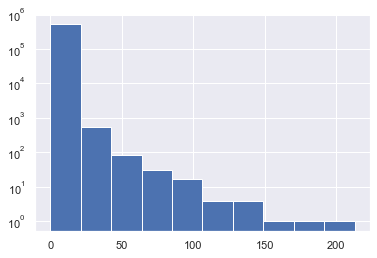

In [39]:
plt.hist(df1_by_users.hours, log= True)
plt.show() # Entre 0 y 25 usuarios son los que más horas jugaron

* Entre 0 y 25 usuarios son los que más horas jugaron.

3. ¿Cómo es la distribución de las horas jugadas?

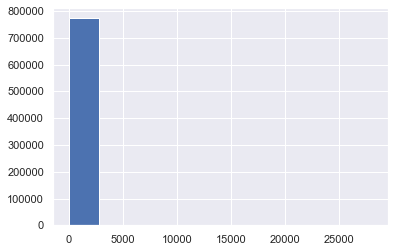

In [40]:
df1['hours'].hist()
plt.show()

* El mayor número de horas jugadas, es de alrededor de 2.500 hs.

4. ¿Cómo es la distribución del número de horas jugadas por usuario?

In [41]:
horas_por_usuario = df1.username.value_counts() # Vemos por usuario, el conteo de dichas calificaciones
horas_por_usuario # 1er columnas es el ID del usuario, la segunda, la cantidad de calificaciones que dió

5463      213
19181     190
65614     155
240929    143
215286    137
         ... 
35667       1
45908       1
47957       1
41814       1
0           1
Name: username, Length: 540339, dtype: int64

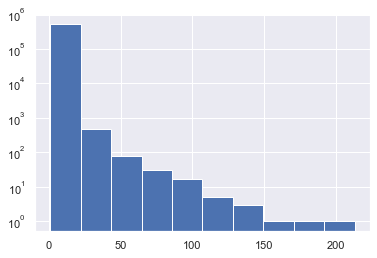

In [42]:
horas_por_usuario.hist(log = True)

* Es el mismo que hicimos arriba, de cantidad de usuarios con más horas jugadas.

5. ¿Cuál es el juego con más horas jugadas?¿Cuántas tiene?¿Y la que menos horas jugadas tiene?

In [43]:
juegos_por_horas = df1.product_id.value_counts() # Hacemos un conteo por película, de los valores únicos por película (para c/ Id de película, cuántos hay)
juegos_por_horas.index = df_title.loc[juegos_por_horas.index].title[1:] # Obtenemos con índice que lo relacionamos con el título, para poder llenar el nombre
juegos_por_horas # La película más jugada es Team Fortress 2

title
Rust                           18373
Borderlands 2                  10221
Fallout 4                       7321
Grand Theft Auto V              7113
Undertale                       5976
                               ...  
Nine Worlds - A Viking saga        1
Hoyle Official Casino Games        1
Expander                           1
Slumlord Simulator                 1
A.I. Space Corps                   1
Name: product_id, Length: 12665, dtype: int64

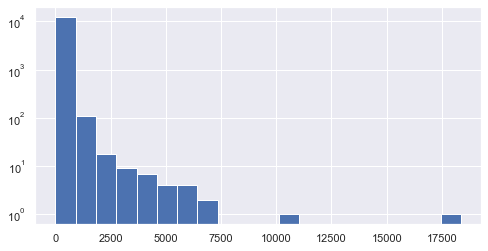

In [47]:
plt.figure(figsize = (8,4))
juegos_por_horas.hist(log = True, bins = 20)
plt.show()

* Son pocos los juegos que tienen muchas horas jugadas.

### 2. ENTRENAMIENTO

Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos? Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [48]:
reader = Reader() # Para que pueda leer Surprise

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

* Un Dataset de Surprise, es muy parecido a un Dataframe de Pandas, sólo que es una estructura que utiliza menos memoria.

In [49]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['username','hours','product_id']][:N_filas], reader) # Decimos cuáles y cuántas filas elegimos
# Cargamos un Dataset, a partir de un Dataframe

In [50]:
trainset, testset = train_test_split(data, test_size=.25) # OJO! Es el de Surprise. Es un Split del Dataset Completo

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [51]:
from surprise import SVD # OJO! Es también es de Surprise!
algo = SVD() # Usamos los hiperparámetros predeterminados

Entrenamos sobre el `trainset`

In [52]:
algo.fit(trainset)

# Entrenamos la Matriz de Utilidad de Train y de Test
# No hay y
# Entrena SVD sobre toda la Matriz de Utilidad (No s/ X e y)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [53]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [54]:
predictions[1] # Predicción para 1 (para un usuario en particular)

# uid: Id del Usuario
# iid: Id del juego
# r_ui: calificación que le da a ese juego en particular (la conocida)
# est: estimación de la calificación (obtenida de SVD)
# was imposible = False: fue posible calificar el juego

Prediction(uid=413680, iid=8.5, r_ui=22320.0, est=5, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y un juego en particular, usamos la función `predict`

In [55]:
algo.predict(1345,28)

Prediction(uid=1345, iid=28, r_ui=None, est=5, details={'was_impossible': False})

* r_ui=None: El usuario no la calificó dicho juego.

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

Juegos que le gustaron

In [56]:
usuario = 7654
horas = 20.5   # le pedimos los juegos a los que haya jugado más de 20.5 hs
df_user = df1[(df1['username'] == usuario) & (df1['hours'] >= horas)]
df_user = df_user.reset_index(drop=True)
df_user['title'] = df_title['title'].loc[df_user.product_id].values
df_user

,username,hours,product_id,title


Creamos donde vamos a guardar las recomendaciones para 1 usuario en particular

In [57]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,NaN


Sacamos del dataframe todas los juegos que ya sabemos que vio

In [58]:
usuario_vistas = df1[df1['username'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(1, 3)


,username,hours,product_id
581094,7654,0.9,340170


Vemos las recomendaciones que ya podemos hacerle a dicho usuario

In [59]:
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,å¼¹ç¸äºº2222
4,773570,NaN


Y hacemos las recomendaciones, con el Id de película específico, y ordenados de mayor a menor.  
Abajo la Recomendación con su valor.

In [60]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [61]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))
# Recomendaciones con valuaciones estimadas por debajo

      product_id                                        title  Estimate_Score
0         761140                          Lost Summoner Kitty               5
2996      336770                             Pilot Brothers 2               5
3002      340290                                     Dr.Green               5
3001      340570                                     WolfWars               5
3000      334300                                 Fake Colours               5
2999      340220                               Shadows of War               5
2998      337070  Dimmdrive :: Gaming Ramdrive @ 10,000+ MB/s               5
2997      336380                              Catmouth Island               5
2995      322170                                Geometry Dash               5
3004      338590                 The Race for the White House               5


### 3. EVALUACIÓN

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [62]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 291113.5150


291113.5149842271

__Nota:__ con `SVD++`, se reducirá aún más el Error.

Después de las recomendaciones de juegos que incluyen calificaciones de juegos, usamos RMSE como evaluaciones de resultados de nuestras recomendaciones. A medida que se amplíe el conjunto de datos, se mejorarán las evaluaciones de RMSE. Lo que significa que nuestras recomendaciones tendrían calificaciones más altas para los usuarios.

### 4. OPTIMIZACIÓN DE PARÁMETROS

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`.

In [63]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256] # Determinamos cuántos valores latentes queremos descubrir

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))
    
# Va a hacer muchas Ejecuciones, y en c/u de ellas va a ir evaluando los resultados (éste es el proceso manual)


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    292763.7178292889.8345293386.3885293013.3136268.7812
Fit time          3.11    3.10    2.69    2.97    0.20    
Test time         0.85    0.79    0.70    0.78    0.06    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    293438.4750292369.7438293230.9756293013.0648462.7169
Fit time          2.57    2.86    2.78    2.73    0.12    
Test time         0.75    0.69    0.84    0.76    0.06    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    294236.2881292654.6765292145.2444293012.0696890.2859
Fit time          2.84    3.50    3.58    3.31    0.33    
Test time         0.78    1.40    0.80    0.99    0.29    

Número de Factores: 8
Evaluating RMSE o

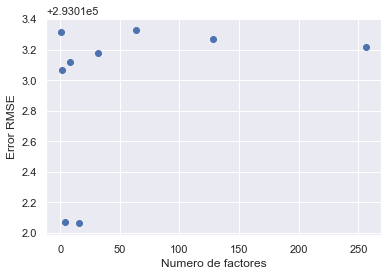

In [64]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Ejercicio**: recordar que, cuando entrenamos un `SVD`, estamos usando descenso por gradiente para minimizar una función de costo. Usar `GridSearchCV` para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): `n_factors`, `n_epochs`, `lr_all` y `reg_all`. Estudiar qué representa cada uno de ellos mientras esperan. Tomarse un café.

In [67]:
# La otra manera de decubrir los valores latentes, pero de forma automática, es a través de Gridsearch

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

# n_jobs = -1: usa todos los cores de procesamiento de la máquina

In [68]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

293013.256655681
{'n_factors': 5, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.002}


En cinco partes,  
que se basan en la popularidad,  
la calidad, el contenido,  
el filtrado colaborativo  
recomendaciones sobre la escala.

Ver usuarios que juegan la misma cantidad de horas cada juego. Esos serán parecidos a mi.

matriz usuario usuario y producto producto

user id horas  
horas product id  
labelencoding de username

modelo con horas  
modelos con metascore

las hacemos por separado

filtro colaborativo  
reduccion de dimensionalidad con SVD